<a href="https://colab.research.google.com/github/Powerlax/ImageClassification/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification Using the Standford Dogs Dataset and Inceptionv3

##Loading the dataset

Note that I have already downloaded the dataset. You can find the dataset here: http://vision.stanford.edu/aditya86/ImageNetDogs/.

Before we can do anything though, let us first import our modules.

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib

Now lets use pathlib to get the windows path to the file. We will then use image_dataset_from_directory() to load the dataset.

In [ ]:
data = pathlib.Path('C:/Users/innav_z3e3dq9/.keras/datasets/PetImages')
print(data)  #printing just to confirm that the first step worked

tds = tf.keras.utils.image_dataset_from_directory(directory=data, validation_split=0.2, subset='training', seed=123, image_size=(224,224)) #training dataset
vds = tf.keras.utils.image_dataset_from_directory(directory=data, validation_split=0.2, subset='validation',seed=123, image_size=(224,224)) #validation dataset

names = tds.class_names
print(names)   #printing to see all of the dog breeds
num = len(names)

C:/Users/innav_z3e3dq9/.keras/datasets/PetImages


NotFoundError: ignored

Now lets do some basic tuning!

In [ ]:
tuner = tf.data.AUTOTUNE
tds = tds.cache().shuffle(1000).prefetch(buffer_size=tuner)
vds = vds.cache().prefetch(buffer_size=tuner)

And now lets do some data augmetnation! This is later we impletemented as its own layer in the final model.

In [ ]:
#add data augmentation for randomness
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224,3)),
    tf.keras.layers.RandomRotation(0.2)
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomCrop(224, 224, 3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    ])

##Building the Model

As mentioned before, we are going to be using the InceptionV3 model to help us. So lets load that now!

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(include_top= False, input_shape= (224, 224, 3), weights= 'imagenet')
for layer in InceptionV3.layers:
  layer.trainable = False

model = tf.keras.Sequential([
      data_aug,
      InceptionV3,
      tf.keras.layers.GlobalAveragePooling2D(), #global average pooling
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(num, activation='softmax')   #softmax because we are making a predection
    ])

Now lets compile the model and see what it looks like!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 262,272
Non-trainable params: 21,802,784
_________________________________________________________________


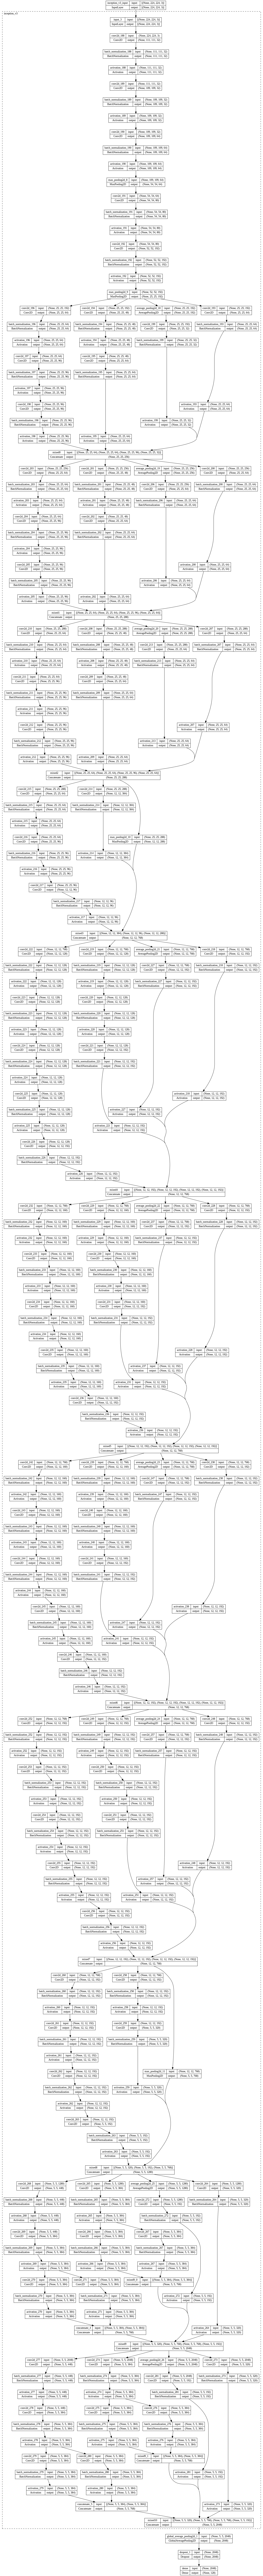

In [ ]:
#model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Now lets do our training and saving!

In [ ]:
model.fit(tds, validation_data=vds, epochs=30)

model.save('baseline_model.h5')

##Predict

Now lets load our model!

In [ ]:
model = new_model = tf.keras.models.load_model('baseline_model.h5', compile=True)
model.summary()

Now for the prediction function!

In [ ]:
def predict(url):
    path = tf.keras.utils.get_file(origin=url)

    img = tf.keras.utils.load_img(
        path, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence.".format(names[np.argmax(score)], 100 * np.max(score))
    )

And finnally, lets wrap it all together!

In [ ]:
cont = True
while cont:
    url = input("Enter image url: ")
    predict(url)
    cont = input("Continue? (y/n) ") == 'y'